# NEXUS tool: case study for the Souss-Massa basin - energy demand calculations
In this notebook a case study for the Souss-Massa basin is covered using the `nexus_tool` package. The water requirements for agricultural irrigation, residential, industrial and tourism use were previously calculated using the Water Evaluation and Planning System (WEAP) model. In this case study, the energy requirements for groundwater pumping, wastewater treatment, desalination of seawater and pumping for water conveyance are estimated.

First import the package by running the following block:

In [1]:
%load_ext autoreload

In [11]:
%autoreload
import os
import nexus_tool
from nexus_tool.weap_tools import create_folder
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from pandas.plotting import register_matplotlib_converters
import plotly.express as px
# register_matplotlib_converters()

In [55]:
scenarios = ['Reference']
load_folder = os.path.join('Data - Souss-Massa', 'Merged data')
results_folder = os.path.join('Morocco dashboard', 'data')
create_folder(results_folder)
for scenario in scenarios:
    scenario_folder = os.path.join(load_folder, scenario)
    create_folder(os.path.join(results_folder, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        create_folder(os.path.join(results_folder, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(results_folder, scenario, sub_scenario, level)
            load_data = os.path.join(sub_scenario_folder, level)
            create_folder(output_folder)
            
            #Define the path to read the scenario input data and reads it in
            file_path = os.path.join(load_data, 'demand_data.csv')
            df = nexus_tool.read_csv(file_path)
            
            #Creates the nexus model with the input dataframe
            souss_massa = nexus_tool.Model(df)
            
            #Define the diameter of the pipelines
            souss_massa.df['Pipe_diameter'] = 0.4
            #Define the variable to take into account for elevation difference and lenght of pipelines
            souss_massa.elevation = 'wtd'
            souss_massa.L = 'wtd'
            
            #Defines the name of the variable for Peak Water Demand and Seasonal Water demand (monthly)
            souss_massa.pwd = 'pwd'
            souss_massa.sswd = 'sswd'
            souss_massa.df.rename(columns={'value': 'sswd'}, inplace=True)
            
            souss_massa.peak_Q = 'pwd'
            souss_massa.avg_Q = 'sswd'
            souss_massa.swpp_e = 'swpp_e'
            souss_massa.pd_e = 'swpp_e'
            souss_massa.swpa_e = 'swpa_e'
            souss_massa.pumping_hours_per_day = 10
            
            #Defines the PWD. It is defined as double the seasonal demand for agricultural sites
            souss_massa.df['pwd'] = souss_massa.df['sswd'] / 3600 / 30 / souss_massa.pumping_hours_per_day #to convert to cubic meter per second [m3/s]
            souss_massa.df.loc[souss_massa.df['type']=='Agriculture', 'pwd'] *= 2
            
            souss_massa.get_A(inplace=True)
            souss_massa.get_V(inplace=True, axis=0)
            souss_massa.get_Re(inplace=True, axis=0)
            souss_massa.get_f(inplace=True, axis=0)

            souss_massa.get_sw_tdh(inplace = True, axis=0)
            souss_massa.get_SWpumping_energy(inplace = True, axis=0)

            file_path = os.path.join(load_data, 'wwtp_inflow.csv')
            df_wwtp = pd.read_csv(file_path)

            wwtp_energy_int = 0.6 # kWh/m3
            df_wwtp['swpa_e'] = df_wwtp.value * wwtp_energy_int
            
            souss_massa.start_year = 2018
            souss_massa.end_year = 2050
            souss_massa.discount_rate = 0.05
            
            souss_massa.create_wind_turbine('Wind power', life=20,
                                            om_cost=0.02, capital_cost=1300,
                                            efficiency=0.6)
            
            souss_massa.create_pv_system('Solar PV', life=15,
                                         om_cost=0.01, capital_cost=1140,
                                         efficiency=0.7)
            
            souss_massa.create_standard_tech('Diesel set', life=10, om_cost=0.1,
                                             capital_cost=938, fuel_cost=0.3,
                                             fuel_req=0.095, efficiency=0.27, cf = 0.5,
                                             emission_factor=2.7, env_cost=0)
            
            souss_massa.create_standard_tech('Grid pump', life=10, om_cost=0.1,
                                             capital_cost=845, fuel_cost=0.1,
                                             fuel_req=1, efficiency=0.55, cf = 0.8,
                                             emission_factor=0.728, env_cost=0)
            
            np.random.seed(1)
            souss_massa.df['wind'] = np.random.randint(5,15,souss_massa.df.shape[0])
            souss_massa.df['srad'] = np.random.randint(22000,50000,souss_massa.df.shape[0])
            
            souss_massa.get_cf('all', axis=0)
            souss_massa.get_installed_capacity('all', axis=0)
            souss_massa.get_max_capacity('a', axis=0)
            souss_massa.get_lcoe(years='all', axis=0)
            
            souss_massa.get_least_cost(technologies='a', years='all', axis=0)
            
#             jordan_gw.df.loc[jordan_gw.df.Year>=2020].to_csv(os.path.join(output_folder, 'Groundwater_pumping.csv'), index=False)
#             df_wwtp.loc[df_wwtp.Year>=2020].to_csv(os.path.join(output_folder, 'wwtp_data.csv'), index=False)

In [56]:
df = souss_massa.lcoe
df.dropna()

Supply point  \
Demand point                           Year                
AEP Taroudant                          2018     Souss GW   
                                       2019     Souss GW   
                                       2020     Souss GW   
                                       2021     Souss GW   
                                       2022     Souss GW   
...                                                  ...   
I_Traditionnel nn Réahbilité 2 Tranche 2046     Souss GW   
                                       2047     Souss GW   
                                       2048     Souss GW   
                                       2049     Souss GW   
                                       2050     Souss GW   

                                                                                          link  \
Demand point                           Year                                                      
AEP Taroudant                          2018      Transmission Link from Souss to AEP Taroudant   
                                       2019      Transmission Link from Souss to AEP Taroudant   
                                       2020      Transmission Link from Souss to AEP Taroudant   
                                       2021      Transmission Link from Souss to AEP Taroudant   
                                       2022      Transmission Link from Souss to AEP Taroudant   
...                                                                                        ...   
I_Traditionnel nn Réahbilité 2 Tranche 2046  Transmission Link from Souss to I_Traditionnel...   
                                       2047  Transmission Link from Souss to I_Traditionnel...   
                                       2048  Transmission Link from Souss to I_Traditionnel...   
                                       2049  Transmission Link from Souss to I_Traditionnel...   
                                       2050  Transmission Link from Souss to I_Traditionnel...   

                                             water demand         type  \
Demand point                           Year                              
AEP Taroudant                          2018  7.855240e+05     Domestic   
                                       2019  2.361130e+06     Domestic   
                                       2020  2.394187e+06     Domestic   
                                       2021  2.427703e+06     Domestic   
                                       2022  2.461692e+06     Domestic   
...                                                   ...          ...   
I_Traditionnel nn Réahbilité 2 Tranche 2046  4.096170e+07  Agriculture   
                                       2047  3.963328e+07  Agriculture   
                                       2048  3.546639e+07  Agriculture   
                                       2049  4.294159e+07  Agriculture   
                                       2050  3.764626e+07  Agriculture   

                                             required capacity  energy demand  \
Demand point                           Year                                     
AEP Taroudant                          2018          86.099818   1.016501e+05   
                                       2019          87.308110   3.055421e+05   
                                       2020          88.532950   3.098289e+05   
                                       2021          89.775211   3.141756e+05   
                                       2022          91.035332   3.185842e+05   
...                                                        ...            ...   
I_Traditionnel nn Réahbilité 2 Tranche 2046       69423.167645   2.244230e+07   
                                       2047       51732.065256   1.770313e+07   
                                       2048       64943.765669   1.699085e+07   
                                       2049       74363.592945   2.128550e+07   
                                       2050       461

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025FDCACA208>,
      dtype=object)

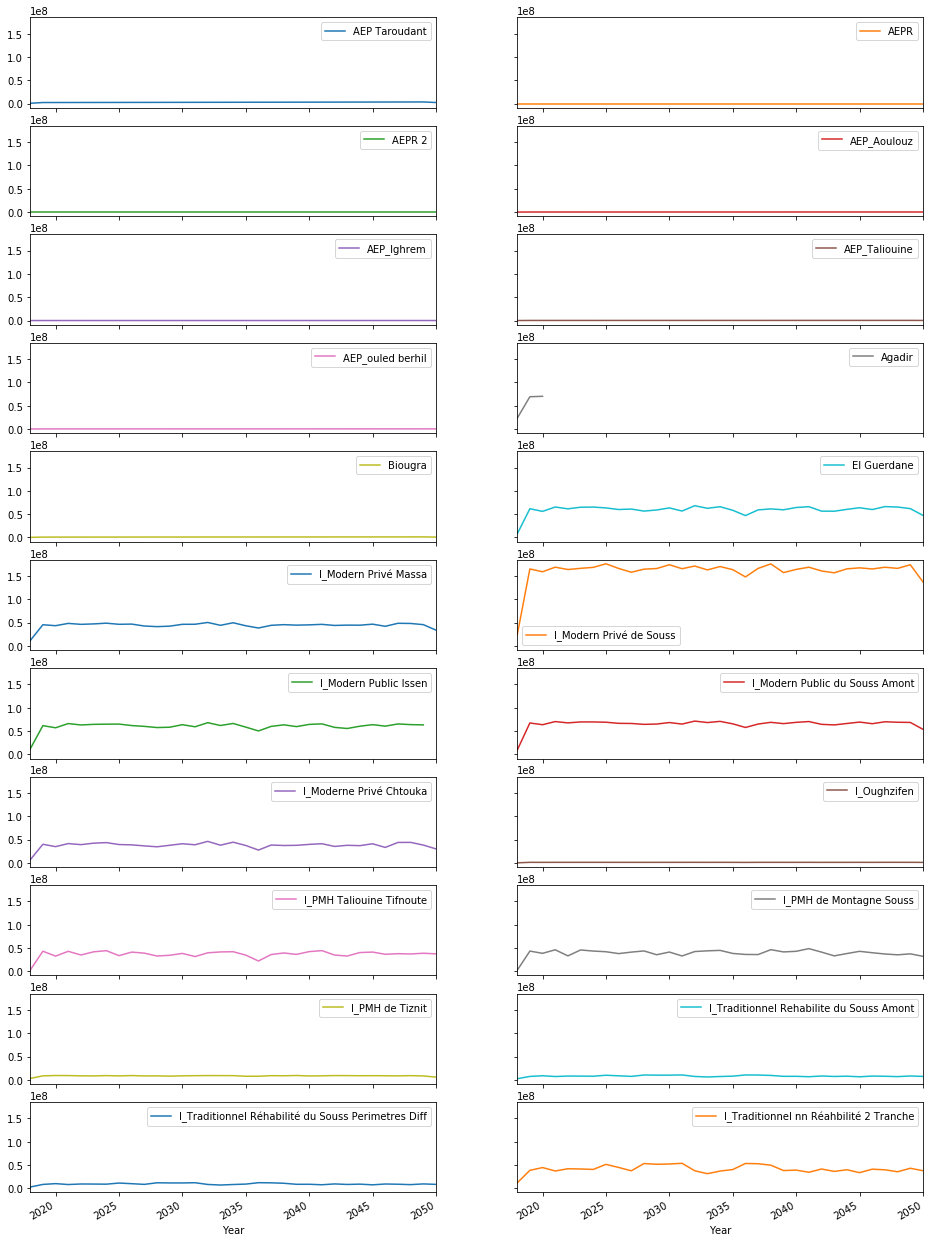

In [58]:
dff = df.reset_index().dropna().pivot('Year','Demand point','water demand')
amount = dff.columns.shape[0]
dff.plot(subplots=True,
         layout=(int(amount/2), 2),
         figsize=(16,24),
         sharey=True
        )

In [29]:
df = souss_massa.technologies['Solar PV'].lcoe
df

,Demand point,discounted_costs,discounted_generation,lcoe,year,technology
0,AEP Rural,191.550514,0.000000e+00,NaN,2018,Solar PV
1,AEP Taroudant,733201.401330,5.779208e+06,0.126869,2018,Solar PV
2,AEPR,195.885273,3.590397e+01,5.455811,2018,Solar PV
3,AEPR 2,199.488797,6.556015e+01,3.042836,2018,Solar PV
4,AEP_Aoulouz,55280.268272,4.272499e+05,0.129386,2018,Solar PV
...,...,...,...,...,...,...
1216,Lakhssass,11.400000,0.000000e+00,NaN,2050,Solar PV
1217,Recharge Souss GW,11.400000,0.000000e+00,NaN,2050,Solar PV
1218,Sidi Ifni,11.400000,0.000000e+00,NaN,2050,Solar PV
1219,Tafraout,11.400000,0.000000e+00,NaN,2050,Solar PV


In [16]:
df = souss_massa.lcoe.dropna()
df.reset_index().pivot('Year','Demand point','least_cost_technology')

Demand point,AEP Taroudant,AEPR,AEPR 2,AEP_Aoulouz,AEP_Ighrem,AEP_Taliouine,AEP_ouled berhil,Agadir,Biougra,El Guerdane,...,I_Modern Public Issen,I_Modern Public du Souss Amont,I_Moderne Privé Chtouka,I_Oughzifen,I_PMH Taliouine Tifnoute,I_PMH de Montagne Souss,I_PMH de Tiznit,I_Traditionnel Rehabilite du Souss Amont,I_Traditionnel Réhabilité du Souss Perimetres Diff,I_Traditionnel nn Réahbilité 2 Tranche
Year,,,,,,,,,,,,,,,,,,,,,
2018,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Diesel set,Grid pump,Grid pump,Grid pump
2019,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Solar PV,Grid pump,Grid pump,Grid pump
2020,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Grid pump,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Solar PV,Grid pump,Grid pump,Grid pump
2021,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,NaN,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Solar PV,Grid pump,Grid pump,Grid pump
2022,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,NaN,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Diesel set,Grid pump,Grid pump,Grid pump
2023,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,NaN,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Diesel set,Grid pump,Grid pump,Grid pump
2024,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,NaN,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Diesel set,Grid pump,Grid pump,Grid pump
2025,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,NaN,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Diesel set,Grid pump,Grid pump,Grid pump
2026,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,Solar PV,NaN,Solar PV,Grid pump,...,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Grid pump,Diesel set,Grid pump,Grid pump,Grid pump


In [25]:
df = pd.DataFrame()
souss_massa.technologies
for key, frame in souss_massa.technologies.items():
    dff = frame.lcoe
    dff['technology'] = key
    df = df.append(dff, ignore_index=True)
df = df.dropna()
df

fig = px.line(df, x="year", y="lcoe", color='technology', facet_row="Demand point", width=1000, height=5000)
fig.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002059DFD08D0>,
      dtype=object)

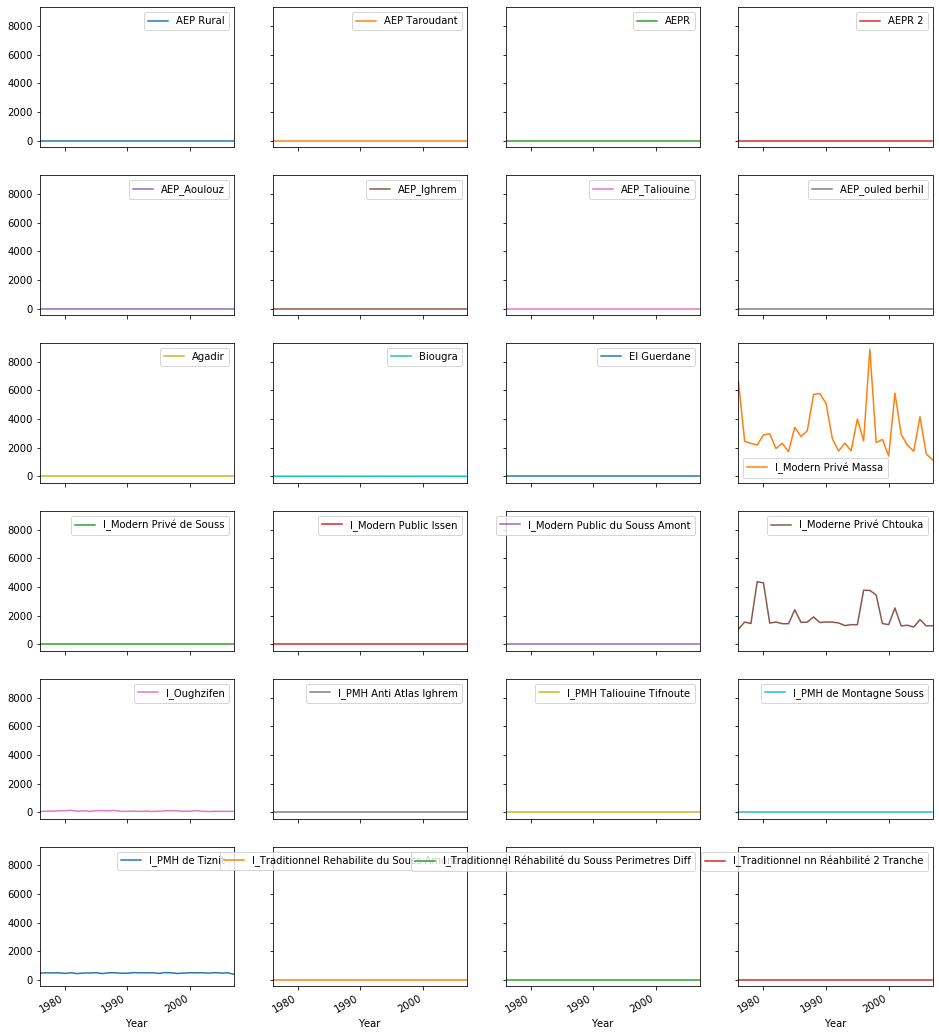

In [78]:
souss_massa.technologies['Solar PV'].max_cap.reset_index().dropna().pivot('Year','Demand point','ic').plot(subplots=True,
                                                                                                           layout=(6, 4),
                                                                                                           figsize=(16,20),
                                                                                                           sharey=True
                                                                                                          )
# dff = souss_massa.df.dropna(subset=['Supply point'])
# dff.loc[dff['Supply point'].str.contains('GW'),['Year','Demand point','sswd']].groupby(['Year','Demand point']).sum().reset_index().dropna().pivot('Year','Demand point','sswd').plot(subplots=True,
#                                                                                                            layout=(6, 4),
#                                                                                                            figsize=(16,20),
#                                                                                                            sharey=True)


In [17]:
souss_massa.df.dropna()

,Year,Month,links,sswd,Demand point,Supply point,type,wtd,Pipe_diameter,pwd,Pipe_area,Flow_velocity_,Re_,f_,tdh_sw,swpp_e,swpa_e,wind,srad
744,1976,9,Transmission Link from Chtouka to I_Modern Pri...,1632074.0,I_Modern Privé Massa,Chtouka GW,Agriculture,48.516384,0.4,3.022359,0.125664,12.025585,0.004810,0.005825,53.724303,2654.817261,3.982226e+05,13,2274
745,1976,10,Transmission Link from Chtouka to I_Modern Pri...,1729627.0,I_Modern Privé Massa,Chtouka GW,Agriculture,48.516384,0.4,3.203013,0.125664,12.744384,0.005098,0.005919,54.459894,2852.024446,4.278037e+05,12,2187
746,1976,11,Transmission Link from Chtouka to I_Modern Pri...,1798983.0,I_Modern Privé Massa,Chtouka GW,Agriculture,48.516384,0.4,3.331450,0.125664,13.255418,0.005302,0.005984,55.016679,2996.714908,4.495072e+05,8,2022
747,1976,12,Transmission Link from Chtouka to I_Modern Pri...,4732116.0,I_Modern Privé Massa,Chtouka GW,Agriculture,48.516384,0.4,8.763178,0.125664,34.867577,0.013947,0.007991,108.574054,15556.268666,2.333440e+06,11,2732
748,1977,1,Transmission Link from Chtouka to I_Modern Pri...,2033111.0,I_Modern Privé Massa,Chtouka GW,Agriculture,48.516384,0.4,3.765020,0.125664,14.980540,0.005992,0.006194,57.108925,3515.515937,5.273274e+05,12,2472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9667,2007,4,Transmission Link from Souss to Agadir,0.0,Agadir,Souss GW,Domestic,28.466103,0.4,0.000000,0.125664,0.000000,0.000000,0.000000,28.466103,0.000000,0.000000e+00,6,2297
9668,2007,5,Transmission Link from Souss to Agadir,0.0,Agadir,Souss GW,Domestic,28.466103,0.4,0.000000,0.125664,0.000000,0.000000,0.000000,28.466103,0.000000,0.000000e+00,8,2870
9669,2007,6,Transmission Link from Souss to Agadir,0.0,Agadir,Souss GW,Domestic,28.466103,0.4,0.000000,0.125664,0.000000,0.000000,0.000000,28.466103,0.000000,0.000000e+00,9,2299
9670,2007,7,Transmission Link from Souss to Agadir,0.0,Agadir,Souss GW,Domestic,28.466103,0.4,0.000000,0.125664,0.000000,0.000000,0.000000,28.466103,0.000000,0.000000e+00,6,2220


In [65]:
water = souss_massa.df.loc[(souss_massa.df.Year==2020)&(souss_massa.df['Supply point'].str.contains('GW'))].sswd.sum()

In [66]:
energy = souss_massa.df.loc[(souss_massa.df.Year==2020)&(souss_massa.df['Supply point'].str.contains('GW'))].swpa_e.sum()

In [67]:
energy/water

3.5735104089848924

In [24]:
souss_massa.df.loc[(souss_massa.df.Year==2020)&(souss_massa.df.type=='Domestic')].groupby(['Year','Demand point'])['sswd','swpa_e'].sum()

sswd         swpa_e
Year Demand point                                 
2018 AEP Rural         0.000000e+00       0.000000
     AEP Taroudant     7.855240e+05  101650.137644
     AEPR              3.660000e+00       0.746931
     AEPR 2            3.660000e+00       1.363886
     AEP_Aoulouz       5.386180e+04    7518.553120
     AEP_Ighrem        2.287934e+04   10335.572338
     AEP_SEl Guerdane  4.861860e+04       0.000000
     AEP_Taliouine     7.960100e+04   11111.519964
     AEP_ouled berhil  7.864780e+04   10167.928123
     Agadir            2.303978e+07   29880.385949
     Ait Baha          6.651660e+01       0.000000
     Biougra           2.807484e+05   61867.567440
     Lakhssass         5.720420e+01       0.000000
     Sidi Ifni         2.449701e+02       0.000000
     Tafraout          6.784680e+01       0.000000
     Tiznit            6.226610e+02       0.000000